# Detección de Valores Anómalos en Dataset

Conjunto de Datos:
https://archive.ics.uci.edu/dataset/186/wine%2Bquality?utm_source=chatgpt.com

## Objetivos
- Explicar e interpretar un **boxplot** (mediana, Q1, Q3, IQR, bigotes, puntos atípicos).
- Aplicar **IQR** y **Z-score/MAD** para **outliers univariados**.
- Aplicar **DBSCAN** para detectar **outliers multivariados** (etiqueta `-1`), con visualizaciones.

## 0) Setup

In [22]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris




def robust_z_scores(series):
    median = series.median()
    mad = (np.abs(series - median)).median()
    if mad == 0:
        return pd.Series(np.zeros(len(series)), index=series.index)
    return (series - median) / (1.4826 * mad)

## 1) Carga de datos


In [23]:
DATA_PATH = "winequality-red.csv"
dataset_name = "Wine Quality"

df = pd.read_csv(DATA_PATH, sep = ";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [24]:
univar_col = "alcohol"

## 2) Exploración inicial del atributo univariado
Elegimos una sola variable continua (`univar_col`) para ilustrar el **boxplot** y los criterios de outliers.

In [25]:
s = pd.to_numeric(df[univar_col], errors="coerce")
s = s.dropna()
print(f"Atributo analizado (univariado): {univar_col}")
print("Estadísticos básicos:")
print(s.describe())

Atributo analizado (univariado): alcohol
Estadísticos básicos:
count    1599.000000
mean       10.422983
std         1.065668
min         8.400000
25%         9.500000
50%        10.200000
75%        11.100000
max        14.900000
Name: alcohol, dtype: float64


### 2.1) Boxplot — ¿qué muestra?
- **Mediana**: línea dentro de la caja (percentil 50).
- **Q1** y **Q3**: percentiles 25 y 75, definen la caja.
- **IQR** = Q3 − Q1: amplitud de la caja.
- **Bigotes**: se extienden hasta los límites típicos `Q1 − 1.5·IQR` y `Q3 + 1.5·IQR` (acotados por los datos).
- **Puntos fuera** de los bigotes: *outliers* potenciales.

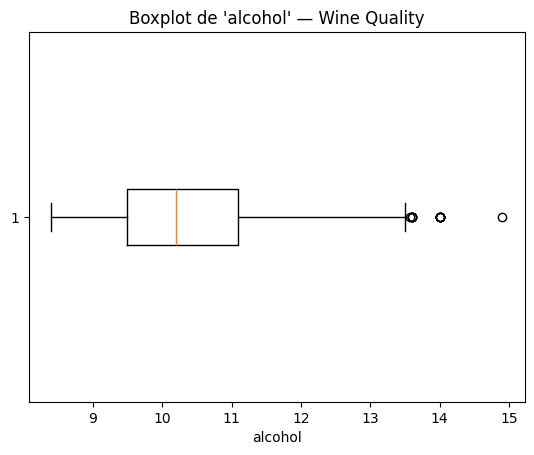

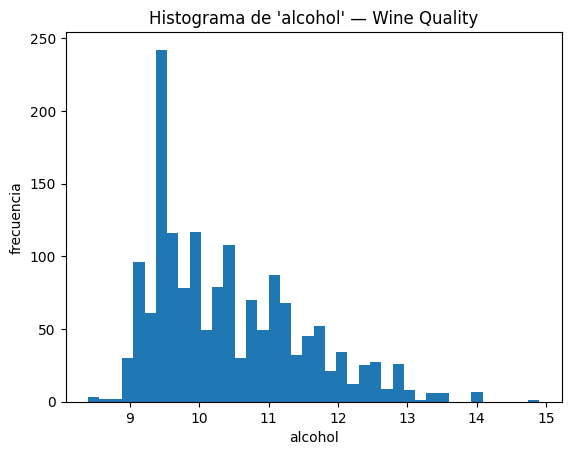

In [26]:
plt.figure()
plt.boxplot(s, vert=False, showfliers=True)
plt.title(f"Boxplot de '{univar_col}' — {dataset_name}")
plt.xlabel(univar_col)
plt.show()

plt.figure()
plt.hist(s, bins=40)
plt.title(f"Histograma de '{univar_col}' — {dataset_name}")
plt.xlabel(univar_col); plt.ylabel("frecuencia")
plt.show()

## 3) Criterio IQR (univariado)
Puntos con valores **< Q1 − 1.5·IQR** o **> Q3 + 1.5·IQR**.

In [28]:
def iqr_bounds(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    return (q1, q3, iqr, q1 - k*iqr, q3 + k*iqr)

In [29]:
s

,alcohol
0,9.4
1,9.8
2,9.8
3,9.8
4,9.4
...,...
1594,10.5
1595,11.2
1596,11.0
1597,10.2


In [30]:
q1, q3, iqr, lower, upper = iqr_bounds(s, k=1.5)
mask_iqr = (s < lower) | (s > upper)
outliers_iqr = s[mask_iqr]

print(f"Q1={q1:.4f}  Q3={q3:.4f}  IQR={iqr:.4f}")
print(f"Límite inferior={lower:.4f}  Límite superior={upper:.4f}")
print("Outliers (IQR):", mask_iqr.sum())

# Vista rápida de los mayores outliers
outliers_iqr.sort_values(ascending=False).head(10)

Q1=9.5000  Q3=11.1000  IQR=1.6000
Límite inferior=7.1000  Límite superior=13.5000
Outliers (IQR): 13


,alcohol
652,14.9
142,14.0
144,14.0
467,14.0
588,14.0
821,14.0
1269,14.0
1270,14.0
1114,13.6
1228,13.6


## 4) Criterio Z-score (clásico) y Z robusto (MAD)
- **Z-score clásico**: `z = (x − μ)/σ` (umbral típico: |z| > 3).
- **Z-score robusto (MAD)**: reemplaza media/desvío por **mediana** y **MAD** (umbral típico: |z| > 3.5).

In [33]:
# Z-score clásico
mu = s.mean()
sigma = s.std(ddof=0) if s.std(ddof=0) != 0 else 1.0
z = (s - mu)/sigma
mask_z = z.abs() > 3.0


summary = pd.DataFrame({
    "value": s,
    "IQR_outlier": mask_iqr.reindex(s.index, fill_value=False),
    "Z_outlier": mask_z.reindex(s.index, fill_value=False),
})

print("Recuento de outliers por criterio:")
print({
    "IQR": int(summary["IQR_outlier"].sum()),
    "Z": int(summary["Z_outlier"].sum()),
})

# Tabla de coincidencias entre criterios
coinc = summary[["IQR_outlier","Z_outlier"]].value_counts().to_frame("count")
coinc

Recuento de outliers por criterio:
{'IQR': 13, 'Z': 8}


count
IQR_outlier Z_outlier       
False       False       1586
True        True           8
            False          5

### 4.1) Visualización de umbrales en el eje (univariado)

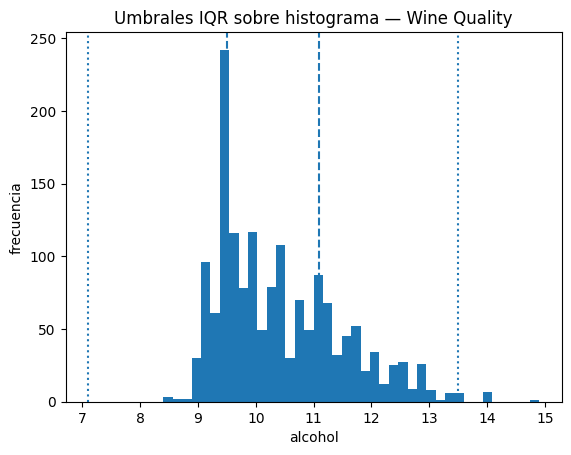

In [34]:
plt.figure()
plt.hist(s, bins=40)
plt.axvline(q1, linestyle="--")
plt.axvline(q3, linestyle="--")
plt.axvline(lower, linestyle=":")
plt.axvline(upper, linestyle=":")
plt.title(f"Umbrales IQR sobre histograma — {dataset_name}")
plt.xlabel(univar_col); plt.ylabel("frecuencia")
plt.show()